<a href="https://colab.research.google.com/github/bdgToji/VNP/blob/main/KOL2_NN_Fetal_Health_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Даден е dataset во кој има податоци поврзани со здравјето на фетусот кај мајките. Целта е да се направи невронска мрежа која ќе овозможува предвидување на состојбата на плодот дадена во колоната fetal_health. Состојбата може да има три различни вредности:
1=Normal
2=Suspect
3=Pathological

Невронската мрежа треба да ги содржи следниве слоеви:
1. Конволуциски слој состваен од 32 неврона, со големина на прозорец 3 и ист padding.
2. Конволуциски слој со 16 неврона, со големина на прозорец 1 и без padding.
3. Dense слој кој ќе има само 10 неврони.
4. Сите слоеви имаат relu активациска функција.

Останатите параметри на мрежата како што се излезниот слој, излезната активациска функција, функцијата на загуба, оптимизатор, метрики за точност, како и останати параметри ако има потреба, потребно е да ги денириате вие.
Дополнително потребо е да се внесе некој механизам за спречување ма overfitting.
Бројот на епохи на кои треба да ја тренирате невронската мрежа е 6 со големина на batch од 32.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Conv1D, Dropout, Input, MaxPooling1D, Flatten, MaxPooling1D
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/drive/MyDrive/VNP/fetal_health.csv')

In [4]:
df

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


# Направете претпроцесирање на податоците

In [5]:
df.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In [6]:
df.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


# Поделето го на тренирачко и тестирачко множество во сооднос 80:20

In [7]:
X, Y = df.drop(columns=['fetal_health']), df['fetal_health']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [8]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test =scaler.transform(X_test)

In [10]:
encoder = OneHotEncoder(sparse=False)

encoder.fit(Y_train.values.reshape(-1,1))
Y_train = encoder.transform(Y_train.values.reshape(-1,1))
Y_test = encoder.transform(Y_test.values.reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
X_train.shape, X_test.shape, Y_train.shape, Y_train.shape

((1700, 21), (426, 21), (1700, 3), (1700, 3))

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
X_train.shape, X_test.shape

((1700, 21, 1), (426, 21, 1))

# Искористете соодветна невронска мрежа

In [14]:
model = Sequential()
model.add(Conv1D(32, 3, padding='same', input_shape=(21,1), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(16, 1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
history = model.fit(X_train, Y_train, epochs=6, batch_size=32, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/6
54/54 - 4s - loss: 0.2682 - accuracy: 0.8947 - val_loss: 0.3212 - val_accuracy: 0.8638 - 4s/epoch - 74ms/step
Epoch 2/6
54/54 - 1s - loss: 0.2552 - accuracy: 0.8947 - val_loss: 0.3111 - val_accuracy: 0.8685 - 637ms/epoch - 12ms/step
Epoch 3/6
54/54 - 1s - loss: 0.2529 - accuracy: 0.8971 - val_loss: 0.3024 - val_accuracy: 0.8732 - 584ms/epoch - 11ms/step
Epoch 4/6
54/54 - 0s - loss: 0.2483 - accuracy: 0.8994 - val_loss: 0.3037 - val_accuracy: 0.8756 - 280ms/epoch - 5ms/step
Epoch 5/6
54/54 - 0s - loss: 0.2498 - accuracy: 0.8982 - val_loss: 0.3010 - val_accuracy: 0.8709 - 297ms/epoch - 5ms/step
Epoch 6/6
54/54 - 0s - loss: 0.2388 - accuracy: 0.9047 - val_loss: 0.2958 - val_accuracy: 0.8779 - 246ms/epoch - 5ms/step


# Тестирајте го моделот на тестирачкото множество со метриките за евалуација на дадениот проблем

In [20]:
model.evaluate(X_test, Y_test)

14/14 [==============================] - 0s 2ms/step - loss: 0.2958 - accuracy: 0.8779


[0.29582372307777405, 0.8779342770576477]

In [22]:
preds = model.predict(X_test)

14/14 [==============================] - 0s 3ms/step


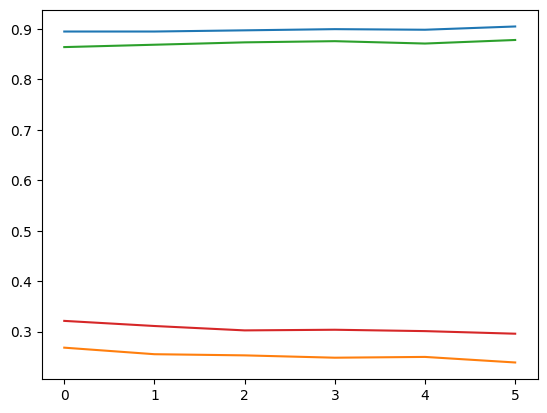

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])

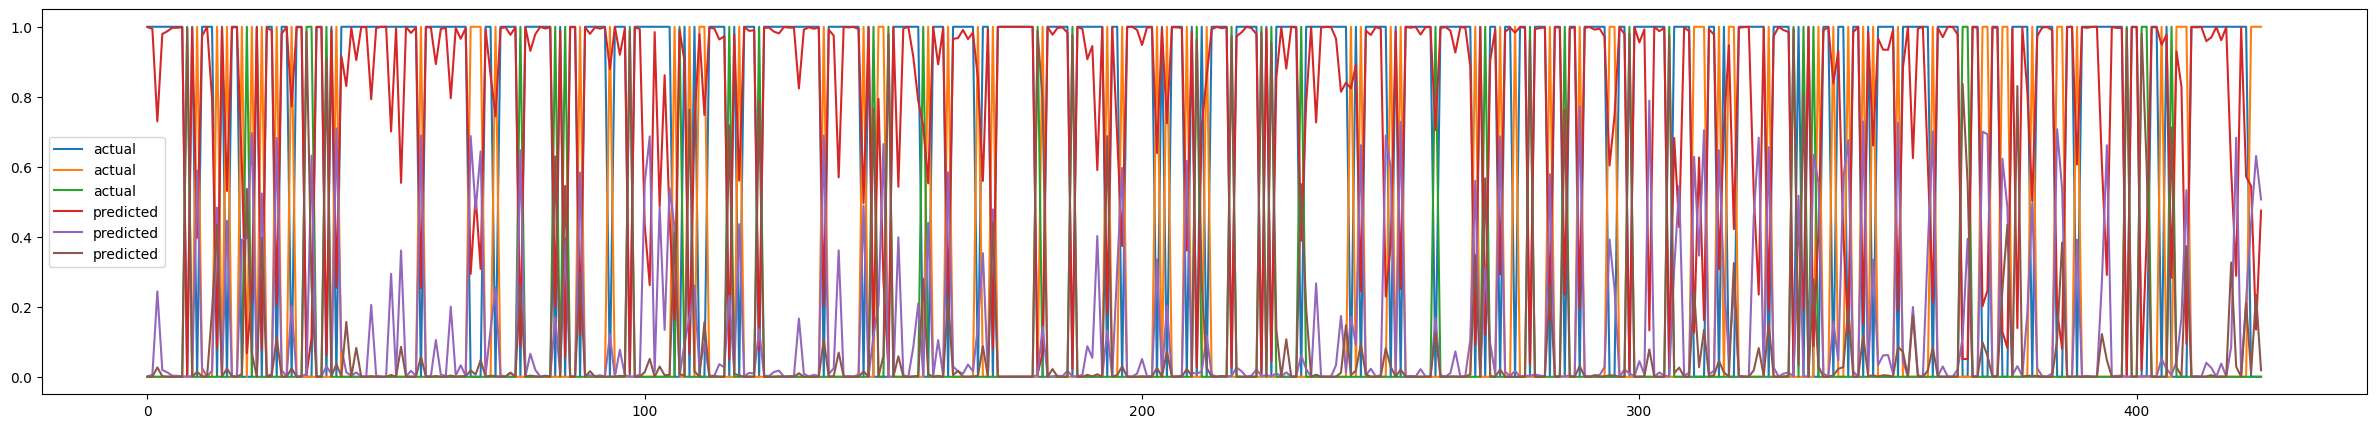

In [24]:
plt.figure(figsize=(30, 5))
plt.plot(Y_test, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()